# Library import

In [1]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

In [2]:
userPATH ='revision_dataset/'
tweetPATH = 'revision_dataset/'

In [3]:
userlvltrain = pd.read_csv(userPATH+'/userlvltrain.csv')
userlvltest = pd.read_csv(userPATH+'/userlvltest.csv')
userlvlval = pd.read_csv(userPATH+'/userlvlval.csv')

In [4]:
train_df = pd.read_csv(tweetPATH+'train_df.csv', keep_default_na=False)
test_df = pd.read_csv(tweetPATH+'test_df.csv', keep_default_na=False)
val_df = pd.read_csv(tweetPATH+'val_df.csv', keep_default_na=False)

In [5]:
## prepare data for BERT training and save in newdata/
if not os.path.exists('newdataVote/'): 
    os.mkdir('newdataVote/')
    train_df.to_csv('newdataVote/train.csv', index=False)
    test_df.to_csv('newdataVote/test.csv', index=False)
    val_df.to_csv('newdataVote/dev.csv', index=False)

possible_labels = train_df.userLocation.unique()
possible_labels.sort()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)
inv_label_dict = {v: k for k, v in label_dict.items()}
print(inv_label_dict)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8}
{0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Setting Cuda

In [6]:
!nvidia-smi

Mon Mar 14 01:36:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    57W / 300W |  19642MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   48C    P0   157W / 300W |  16998MiB / 32480MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [7]:
torch.cuda.set_device(3)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device_idx = "cuda:3"
torch.cuda.current_device()

3

In [8]:
import random 
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

def location_prediction_metrics(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics


class LocationPredictionDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = label_dict
    INDEX2LABEL = inv_label_dict
    NUM_LABELS = 9
    
    def load_dataset(self, path): 
        df = pd.read_csv(path, sep=',')
        # df.columns = ['screenName','tweets','userLocation', 'mentionedLocation','label', 'final_feat']
        df['userLocation'] = df['userLocation'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        tweets, labels = data['text'], data['userLocation']
        subwords = self.tokenizer.encode(tweets, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), data['text']
    
    def __len__(self):
        return len(self.data)    
        
class LocationPredictionDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(LocationPredictionDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        class_batch = np.zeros((batch_size, 1), dtype=np.int64)
        
        seq_list = []
        for i, (subwords, tagging, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            class_batch[i,0] = tagging
            
            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, class_batch, seq_list

# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == device_idx:
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label

# Save and Load Functions

# pada fungsi ini dilakukan penyimpanan model, optimizer, dan validation loss
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)

# untuk meload loss yang telah disimpan
def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# pada fungsi ini accuracy dan loss disimpan 
def save_metrics(save_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs):

    if save_path == None:
        return
    
    state_dict = {'train_acc_list': train_acc_list,
                  'train_loss_list': train_loss_list,
                  'valid_acc_list': valid_acc_list,
                  'valid_loss_list': valid_loss_list,
                  'epochs_list': epochs}
    
    torch.save(state_dict, save_path)
    # print(f'Model saved to ==> {save_path}')

# fungsi untuk melakukan load accuracy dan loss 
def load_metrics(load_path): 

    if load_path==None:
        return
    state_dict = torch.load(load_path)    
    
    return state_dict['train_acc_list'],state_dict['train_loss_list'], state_dict['valid_acc_list'], state_dict['valid_loss_list'], state_dict['epochs_list']

## Prepare Dataset

In [9]:
set_seed(42)

#Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')
config = BertConfig.from_pretrained('indolem/indobert-base-uncased',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
config.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', 
                                                      config=config)

train_dataset = LocationPredictionDataset("newdataVote/train.csv", tokenizer, lowercase=True)
valid_dataset = LocationPredictionDataset("newdataVote/dev.csv", tokenizer, lowercase=True)
test_dataset = LocationPredictionDataset("newdataVote/test.csv", tokenizer, lowercase=True)


learning_rate = 1e-5
batch_size = 16
epochs = 4

train_loader = LocationPredictionDataLoader(dataset=train_dataset, max_seq_len=280, batch_size=batch_size, num_workers=16, shuffle=True)  
valid_loader = LocationPredictionDataLoader(dataset=valid_dataset, max_seq_len=280, batch_size=batch_size, num_workers=16, shuffle=False)  
test_loader = LocationPredictionDataLoader(dataset=test_dataset, max_seq_len=280, batch_size=batch_size, num_workers=16, shuffle=False)

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indober

In [10]:
w2i, i2w = LocationPredictionDataset.LABEL2INDEX, LocationPredictionDataset.INDEX2LABEL
print(w2i, '\n', i2w)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8} 
 {0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Fine Tuning and Evaluation

In [11]:
torch.cuda.empty_cache()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model = model.to(device)

### training

In [12]:
file_path = 'saved_model_vote/'
if not os.path.exists(file_path): 
    os.mkdir(file_path)

model_name = 'indoLEM_model'
metrics_name = 'indoLEM_metrics'

model_path = file_path+model_name+'_'+str(batch_size)+'_'+str(epochs)+'_'+str(learning_rate)+'.pt'
metrics_path = file_path+metrics_name+'_'+str(batch_size)+'_'+str(epochs)+'_'+str(learning_rate)+'.pt'

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# list untuk menyimpan data metrics setiap training, untuk memudahkan 
# menampilkan dalam grafik
train_acc_list = [] 
train_loss_list = []
valid_acc_list = [] 
valid_loss_list = []
epochs_list = []

best_valid_loss = float("Inf")
file_path = 'saved_model'

# Train
n_epochs = epochs
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))

    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    train_loss_list.append(total_train_loss/(i+1))
    train_acc_list.append(metrics['ACC'])
    epochs_list.append(epoch)


    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))

    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = location_prediction_metrics(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    valid_loss_list.append(total_loss/(i+1))
    valid_acc_list.append(metrics['ACC'])

    # checkpoint, untuk menyimpan validation loss dan metrics yang paling baik untuk seluruh epochs 
    if best_valid_loss > total_loss/(i+1):
      best_valid_loss = total_loss/(i+1)
      save_checkpoint(model_path, model, optimizer, best_valid_loss)

save_metrics(metrics_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list)
print('Done Training!')

(Epoch 1) TRAIN LOSS:2.1972 LR:0.00001000: 100%|██████████| 5337/5337 [05:47<00:00, 15.35it/s]


(Epoch 1) TRAIN LOSS:2.1972 ACC:0.13 F1:0.09 REC:0.11 PRE:0.11 LR:0.00001000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0859 ACC:0.00 F1:0.00 REC:0.00 PRE:0.00:   0%|          | 1/583 [00:01<10:15,  1.06s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

VALID LOSS:2.0743 ACC:0.26 F1:0.14 REC:0.33 PRE:0.09:   3%|▎         | 16/583 [00:01<00:30, 18.77it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0832 ACC:0.25 F1:0.10 REC:0.25 PRE:0.06:   3%|▎         | 16/583 [00:01<00:30, 18.77it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0912 ACC:0.24 F1:0.10 REC:0.25 PRE:0.06:   3%|▎         | 16/583 [00:01<00:30, 18.77it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0782 ACC:0.12 F1:0.04 REC:0.17 PRE:0.02:   6%|▌         | 36/583 [00:01<00:16, 32.74it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0766 ACC:0.12 F1:0.03 REC:0.17 PRE:0.02:   6%|▌         | 36/583 [00:01<00:16, 32.74it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0727 ACC:0.11 F1:0.03 REC:0.17 PRE:0.02:   7%|▋         | 40/583 [00:01<00:16, 33.73it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0903 ACC:0.08 F1:0.02 REC:0.14 PRE:0.01:  10%|▉         | 56/583 [00:02<00:16, 31.59it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0968 ACC:0.07 F1:0.02 REC:0.14 PRE:0.01:  10%|█         | 60/583 [00:02<00:16, 31.25it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1030 ACC:0.07 F1:0.02 REC:0.14 PRE:0.01:  10%|█         | 60/583 [00:02<00:16, 31.25it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0983 ACC:0.06 F1:0.02 REC:0.14 PRE:0.01:  14%|█▎        | 80/583 [00:03<00:18, 26.65it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0982 ACC:0.06 F1:0.02 REC:0.14 PRE:0.01:  14%|█▎        | 80/583 [00:03<00:18, 26.65it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0980 ACC:0.05 F1:0.01 REC:0.14 PRE:0.01:  14%|█▎        | 80/583 [00:03<00:18, 26.65it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.1668 ACC:0.04 F1:0.01 REC:0.12 PRE:0.01:  17%|█▋        | 101/583 [00:04<00:20, 23.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1663 ACC:0.04 F1:0.01 REC:0.12 PRE:0.01:  17%|█▋        | 101/583 [00:04<00:20, 23.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1655 ACC:0.04 F1:0.01 REC:0.12 PRE:0.01:  17%|█▋        | 101/583 [00:04<00:20, 23.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1908 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  21%|██        | 122/583 [00:05<00:22, 20.17it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1900 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  21%|██        | 122/583 [00:05<00:22, 20.17it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1893 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  21%|██        | 122/583 [00:05<00:22, 20.17it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2131 ACC:0.03 F1:0.01 REC:0.11 PRE:0.00:  24%|██▍       | 142/583 [00:06<00:26, 16.69it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2149 ACC:0.03 F1:0.01 REC:0.11 PRE:0.00:  25%|██▍       | 144/583 [00:06<00:25, 16.95it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2167 ACC:0.03 F1:0.01 REC:0.11 PRE:0.00:  25%|██▍       | 144/583 [00:06<00:25, 16.95it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2072 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  28%|██▊       | 164/583 [00:07<00:25, 16.15it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2108 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  28%|██▊       | 164/583 [00:07<00:25, 16.15it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2143 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  28%|██▊       | 166/583 [00:07<00:26, 15.87it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2331 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  32%|███▏      | 184/583 [00:09<00:27, 14.47it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2337 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  32%|███▏      | 186/583 [00:09<00:27, 14.58it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2348 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  32%|███▏      | 186/583 [00:09<00:27, 14.58it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2699 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  35%|███▌      | 206/583 [00:10<00:27, 13.51it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2702 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  35%|███▌      | 206/583 [00:10<00:27, 13.51it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2705 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  36%|███▌      | 208/583 [00:10<00:27, 13.57it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2577 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  39%|███▉      | 226/583 [00:12<00:27, 12.81it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2562 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  39%|███▉      | 228/583 [00:12<00:27, 12.69it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2548 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  39%|███▉      | 228/583 [00:12<00:27, 12.69it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2694 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  43%|████▎     | 248/583 [00:14<00:28, 11.69it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2707 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  43%|████▎     | 248/583 [00:14<00:28, 11.69it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2693 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  43%|████▎     | 250/583 [00:14<00:28, 11.66it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2506 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  46%|████▌     | 268/583 [00:16<00:28, 11.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2490 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  46%|████▋     | 270/583 [00:16<00:28, 10.84it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2470 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  46%|████▋     | 270/583 [00:16<00:28, 10.84it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2378 ACC:0.08 F1:0.02 REC:0.11 PRE:0.01:  50%|████▉     | 289/583 [00:18<00:29,  9.81it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2397 ACC:0.08 F1:0.02 REC:0.11 PRE:0.01:  50%|████▉     | 291/583 [00:18<00:29,  9.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2417 ACC:0.08 F1:0.02 REC:0.11 PRE:0.01:  50%|█████     | 292/583 [00:18<00:29,  9.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2532 ACC:0.07 F1:0.02 REC:0.11 PRE:0.01:  53%|█████▎    | 310/583 [00:20<00:28,  9.48it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2527 ACC:0.07 F1:0.02 REC:0.11 PRE:0.01:  54%|█████▎    | 312/583 [00:20<00:28,  9.64it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2522 ACC:0.07 F1:0.02 REC:0.11 PRE:0.01:  54%|█████▎    | 313/583 [00:20<00:28,  9.55it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2470 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  57%|█████▋    | 332/583 [00:22<00:27,  9.07it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2470 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  57%|█████▋    | 333/583 [00:22<00:28,  8.85it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2470 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  57%|█████▋    | 334/583 [00:22<00:28,  8.68it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2497 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  61%|██████    | 353/583 [00:24<00:27,  8.39it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2493 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  61%|██████    | 354/583 [00:25<00:27,  8.33it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2488 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  61%|██████    | 355/583 [00:25<00:26,  8.46it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2472 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  64%|██████▍   | 374/583 [00:27<00:24,  8.69it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2468 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  64%|██████▍   | 375/583 [00:27<00:23,  8.73it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2458 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  64%|██████▍   | 376/583 [00:27<00:23,  8.73it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2256 ACC:0.09 F1:0.02 REC:0.11 PRE:0.01:  68%|██████▊   | 395/583 [00:30<00:22,  8.29it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2243 ACC:0.09 F1:0.02 REC:0.11 PRE:0.01:  68%|██████▊   | 396/583 [00:30<00:22,  8.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2230 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  68%|██████▊   | 397/583 [00:30<00:22,  8.34it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2212 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  71%|███████▏  | 416/583 [00:32<00:21,  7.59it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2214 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  72%|███████▏  | 417/583 [00:32<00:21,  7.56it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2217 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  72%|███████▏  | 418/583 [00:32<00:21,  7.60it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2149 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  75%|███████▍  | 437/583 [00:35<00:19,  7.47it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2149 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  75%|███████▌  | 438/583 [00:35<00:19,  7.31it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2149 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  75%|███████▌  | 439/583 [00:35<00:19,  7.35it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2152 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  79%|███████▊  | 458/583 [00:38<00:17,  7.17it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2149 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  79%|███████▊  | 459/583 [00:38<00:17,  7.17it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2143 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  79%|███████▉  | 460/583 [00:38<00:17,  7.15it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1991 ACC:0.12 F1:0.02 REC:0.11 PRE:0.01:  82%|████████▏ | 479/583 [00:41<00:15,  6.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1980 ACC:0.12 F1:0.02 REC:0.11 PRE:0.01:  82%|████████▏ | 480/583 [00:41<00:14,  6.91it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1970 ACC:0.12 F1:0.02 REC:0.11 PRE:0.01:  83%|████████▎ | 481/583 [00:41<00:15,  6.62it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1923 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  86%|████████▌ | 500/583 [00:44<00:12,  6.60it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1925 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  86%|████████▌ | 501/583 [00:44<00:12,  6.53it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1928 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  86%|████████▌ | 502/583 [00:44<00:12,  6.51it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1953 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  89%|████████▉ | 521/583 [00:47<00:09,  6.46it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1944 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  90%|████████▉ | 522/583 [00:48<00:09,  6.45it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1934 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  90%|████████▉ | 523/583 [00:48<00:09,  6.45it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1964 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  93%|█████████▎| 542/583 [00:51<00:06,  6.35it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1962 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  93%|█████████▎| 543/583 [00:51<00:06,  6.33it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1960 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  93%|█████████▎| 544/583 [00:51<00:06,  6.36it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1915 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  97%|█████████▋| 563/583 [00:54<00:03,  6.05it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1912 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  97%|█████████▋| 564/583 [00:54<00:03,  5.94it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1913 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  97%|█████████▋| 565/583 [00:54<00:03,  5.88it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

(Epoch 1) VALID LOSS:2.1937 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02


(Epoch 2) TRAIN LOSS:2.1912 LR:0.00001000: 100%|██████████| 5337/5337 [05:44<00:00, 15.51it/s]


(Epoch 2) TRAIN LOSS:2.1912 ACC:0.14 F1:0.08 REC:0.11 PRE:0.11 LR:0.00001000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0247 ACC:0.00 F1:0.00 REC:0.00 PRE:0.00:   0%|          | 1/583 [00:01<10:08,  1.05s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

VALID LOSS:2.0568 ACC:0.26 F1:0.14 REC:0.33 PRE:0.09:   3%|▎         | 16/583 [00:01<00:30, 18.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0752 ACC:0.25 F1:0.10 REC:0.25 PRE:0.06:   3%|▎         | 16/583 [00:01<00:30, 18.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0917 ACC:0.24 F1:0.10 REC:0.25 PRE:0.06:   3%|▎         | 16/583 [00:01<00:30, 18.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0830 ACC:0.12 F1:0.04 REC:0.17 PRE:0.02:   6%|▌         | 36/583 [00:01<00:16, 32.59it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0823 ACC:0.12 F1:0.03 REC:0.17 PRE:0.02:   6%|▌         | 36/583 [00:01<00:16, 32.59it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0769 ACC:0.11 F1:0.03 REC:0.17 PRE:0.02:   7%|▋         | 40/583 [00:01<00:16, 33.85it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0971 ACC:0.08 F1:0.02 REC:0.14 PRE:0.01:  10%|▉         | 56/583 [00:02<00:16, 31.19it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1026 ACC:0.07 F1:0.02 REC:0.14 PRE:0.01:  10%|█         | 60/583 [00:02<00:16, 31.40it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1080 ACC:0.07 F1:0.02 REC:0.14 PRE:0.01:  10%|█         | 60/583 [00:02<00:16, 31.40it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0886 ACC:0.06 F1:0.02 REC:0.14 PRE:0.01:  13%|█▎        | 78/583 [00:03<00:19, 26.47it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0879 ACC:0.06 F1:0.02 REC:0.14 PRE:0.01:  14%|█▍        | 81/583 [00:03<00:19, 26.23it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0871 ACC:0.05 F1:0.01 REC:0.14 PRE:0.01:  14%|█▍        | 81/583 [00:03<00:19, 26.23it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.1501 ACC:0.04 F1:0.01 REC:0.12 PRE:0.01:  17%|█▋        | 99/583 [00:04<00:20, 23.61it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1492 ACC:0.04 F1:0.01 REC:0.12 PRE:0.01:  17%|█▋        | 102/583 [00:04<00:20, 22.99it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1479 ACC:0.04 F1:0.01 REC:0.12 PRE:0.01:  17%|█▋        | 102/583 [00:04<00:20, 22.99it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricW

VALID LOSS:2.1709 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  21%|██        | 120/583 [00:05<00:22, 20.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1712 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  21%|██        | 123/583 [00:05<00:22, 20.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1714 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  21%|██        | 123/583 [00:05<00:22, 20.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1923 ACC:0.03 F1:0.01 REC:0.11 PRE:0.00:  25%|██▍       | 143/583 [00:06<00:24, 17.84it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1939 ACC:0.03 F1:0.01 REC:0.11 PRE:0.00:  25%|██▍       | 143/583 [00:06<00:24, 17.84it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1955 ACC:0.03 F1:0.01 REC:0.11 PRE:0.00:  25%|██▍       | 145/583 [00:06<00:24, 17.96it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1912 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  28%|██▊       | 163/583 [00:07<00:25, 16.64it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1937 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  28%|██▊       | 165/583 [00:07<00:25, 16.67it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1961 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  28%|██▊       | 165/583 [00:07<00:25, 16.67it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2051 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  32%|███▏      | 185/583 [00:09<00:26, 15.03it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2056 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  32%|███▏      | 185/583 [00:09<00:26, 15.03it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2065 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  32%|███▏      | 187/583 [00:09<00:26, 14.96it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2356 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  35%|███▌      | 205/583 [00:10<00:27, 13.63it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2359 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  36%|███▌      | 207/583 [00:10<00:27, 13.60it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2361 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  36%|███▌      | 207/583 [00:10<00:27, 13.60it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2308 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  39%|███▉      | 227/583 [00:12<00:27, 13.01it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2292 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  39%|███▉      | 227/583 [00:12<00:27, 13.01it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2276 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  39%|███▉      | 229/583 [00:12<00:27, 12.83it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2408 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  42%|████▏     | 247/583 [00:13<00:28, 11.95it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2421 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  43%|████▎     | 249/583 [00:14<00:28, 11.86it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2410 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  43%|████▎     | 249/583 [00:14<00:28, 11.86it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2213 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  46%|████▌     | 269/583 [00:15<00:28, 11.04it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2198 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  46%|████▌     | 269/583 [00:15<00:28, 11.04it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2182 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  46%|████▋     | 271/583 [00:15<00:27, 11.16it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2165 ACC:0.08 F1:0.02 REC:0.11 PRE:0.01:  50%|████▉     | 289/583 [00:17<00:27, 10.51it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2178 ACC:0.08 F1:0.02 REC:0.11 PRE:0.01:  50%|████▉     | 291/583 [00:17<00:28, 10.31it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2191 ACC:0.08 F1:0.02 REC:0.11 PRE:0.01:  50%|████▉     | 291/583 [00:17<00:28, 10.31it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2295 ACC:0.07 F1:0.02 REC:0.11 PRE:0.01:  53%|█████▎    | 311/583 [00:19<00:27,  9.94it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2294 ACC:0.07 F1:0.02 REC:0.11 PRE:0.01:  54%|█████▎    | 312/583 [00:19<00:27,  9.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2294 ACC:0.07 F1:0.02 REC:0.11 PRE:0.01:  54%|█████▎    | 312/583 [00:20<00:27,  9.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2225 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  57%|█████▋    | 332/583 [00:22<00:27,  9.23it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2230 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  57%|█████▋    | 333/583 [00:22<00:27,  9.23it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2235 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  57%|█████▋    | 334/583 [00:22<00:27,  9.09it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2255 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  61%|██████    | 353/583 [00:24<00:26,  8.59it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2254 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  61%|██████    | 354/583 [00:24<00:26,  8.53it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2253 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  61%|██████    | 355/583 [00:24<00:26,  8.57it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2266 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  64%|██████▍   | 374/583 [00:26<00:25,  8.26it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2260 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  64%|██████▍   | 375/583 [00:27<00:25,  8.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2252 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  64%|██████▍   | 376/583 [00:27<00:24,  8.30it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2073 ACC:0.09 F1:0.02 REC:0.11 PRE:0.01:  68%|██████▊   | 395/583 [00:29<00:24,  7.69it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2062 ACC:0.09 F1:0.02 REC:0.11 PRE:0.01:  68%|██████▊   | 396/583 [00:29<00:23,  7.83it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2051 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  68%|██████▊   | 397/583 [00:29<00:23,  7.84it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2043 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  71%|███████▏  | 416/583 [00:32<00:22,  7.43it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2045 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  72%|███████▏  | 417/583 [00:32<00:22,  7.47it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2047 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  72%|███████▏  | 418/583 [00:32<00:21,  7.50it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1990 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  75%|███████▍  | 437/583 [00:35<00:20,  7.17it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1995 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  75%|███████▌  | 438/583 [00:35<00:20,  7.11it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1999 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  75%|███████▌  | 439/583 [00:35<00:20,  7.12it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2035 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  79%|███████▊  | 458/583 [00:38<00:17,  7.09it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2035 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  79%|███████▊  | 459/583 [00:38<00:17,  6.96it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2028 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  79%|███████▉  | 460/583 [00:38<00:17,  6.98it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1879 ACC:0.12 F1:0.02 REC:0.11 PRE:0.01:  82%|████████▏ | 479/583 [00:41<00:15,  6.56it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1870 ACC:0.12 F1:0.02 REC:0.11 PRE:0.01:  82%|████████▏ | 480/583 [00:41<00:15,  6.59it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1862 ACC:0.12 F1:0.02 REC:0.11 PRE:0.01:  83%|████████▎ | 481/583 [00:41<00:15,  6.52it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1823 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  86%|████████▌ | 500/583 [00:44<00:13,  6.34it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1825 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  86%|████████▌ | 501/583 [00:44<00:12,  6.34it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1828 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  86%|████████▌ | 502/583 [00:44<00:12,  6.30it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1858 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  89%|████████▉ | 521/583 [00:47<00:09,  6.22it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1850 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  90%|████████▉ | 522/583 [00:48<00:09,  6.19it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1842 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  90%|████████▉ | 523/583 [00:48<00:09,  6.09it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1866 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  93%|█████████▎| 542/583 [00:51<00:06,  5.99it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1863 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  93%|█████████▎| 543/583 [00:51<00:06,  5.93it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1860 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  93%|█████████▎| 544/583 [00:51<00:06,  5.96it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1860 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  97%|█████████▋| 563/583 [00:55<00:03,  5.73it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1859 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  97%|█████████▋| 564/583 [00:55<00:03,  5.65it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1863 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  97%|█████████▋| 565/583 [00:55<00:03,  5.51it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

(Epoch 2) VALID LOSS:2.1915 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02


(Epoch 3) TRAIN LOSS:2.1872 LR:0.00001000: 100%|██████████| 5337/5337 [05:47<00:00, 15.38it/s]


(Epoch 3) TRAIN LOSS:2.1872 ACC:0.14 F1:0.08 REC:0.11 PRE:0.11 LR:0.00001000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9854 ACC:0.00 F1:0.00 REC:0.00 PRE:0.00:   0%|          | 1/583 [00:01<10:22,  1.07s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

VALID LOSS:1.9782 ACC:0.00 F1:0.00 REC:0.00 PRE:0.00:   2%|▏         | 12/583 [00:01<00:42, 13.48it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0038 ACC:0.00 F1:0.00 REC:0.00 PRE:0.00:   2%|▏         | 12/583 [00:01<00:42, 13.48it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter

VALID LOSS:2.0958 ACC:0.00 F1:0.00 REC:0.00 PRE:0.00:   4%|▍         | 22/583 [00:01<00:23, 24.19it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0914 ACC:0.00 F1:0.00 REC:0.00 PRE:0.00:   4%|▍         | 22/583 [00:01<00:23, 24.19it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter

VALID LOSS:2.0318 ACC:0.21 F1:0.06 REC:0.17 PRE:0.04:   7%|▋         | 39/583 [00:02<00:17, 31.98it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0272 ACC:0.23 F1:0.06 REC:0.17 PRE:0.04:   7%|▋         | 39/583 [00:02<00:17, 31.98it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0229 ACC:0.25 F1:0.07 REC:0.17 PRE:0.04:   7%|▋         | 43/583 [00:02<00:16, 33.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0648 ACC:0.20 F1:0.05 REC:0.14 PRE:0.03:  10%|█         | 59/583 [00:02<00:16, 32.22it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0718 ACC:0.20 F1:0.05 REC:0.14 PRE:0.03:  11%|█         | 63/583 [00:02<00:15, 32.66it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0741 ACC:0.20 F1:0.05 REC:0.14 PRE:0.03:  11%|█         | 63/583 [00:02<00:15, 32.66it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0465 ACC:0.23 F1:0.05 REC:0.14 PRE:0.03:  14%|█▍        | 82/583 [00:03<00:17, 28.92it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0496 ACC:0.22 F1:0.05 REC:0.14 PRE:0.03:  14%|█▍        | 82/583 [00:03<00:17, 28.92it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0527 ACC:0.22 F1:0.05 REC:0.14 PRE:0.03:  15%|█▍        | 85/583 [00:03<00:17, 28.16it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.1270 ACC:0.18 F1:0.03 REC:0.11 PRE:0.02:  18%|█▊        | 103/583 [00:04<00:20, 23.51it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1319 ACC:0.18 F1:0.03 REC:0.11 PRE:0.02:  18%|█▊        | 103/583 [00:04<00:20, 23.51it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1336 ACC:0.18 F1:0.03 REC:0.11 PRE:0.02:  18%|█▊        | 106/583 [00:04<00:20, 23.48it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1536 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  21%|██▏       | 124/583 [00:05<00:21, 21.20it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1511 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  21%|██▏       | 124/583 [00:05<00:21, 21.20it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1487 ACC:0.17 F1:0.03 REC:0.11 PRE:0.02:  22%|██▏       | 127/583 [00:05<00:21, 20.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1940 ACC:0.17 F1:0.03 REC:0.11 PRE:0.02:  25%|██▍       | 145/583 [00:06<00:22, 19.70it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1962 ACC:0.17 F1:0.03 REC:0.11 PRE:0.02:  25%|██▌       | 147/583 [00:06<00:22, 19.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1983 ACC:0.17 F1:0.03 REC:0.11 PRE:0.02:  25%|██▌       | 147/583 [00:06<00:22, 19.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2010 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  29%|██▊       | 167/583 [00:07<00:24, 17.13it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2036 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  29%|██▊       | 167/583 [00:07<00:24, 17.13it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2014 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  29%|██▉       | 169/583 [00:07<00:24, 17.20it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2124 ACC:0.17 F1:0.03 REC:0.11 PRE:0.02:  32%|███▏      | 187/583 [00:08<00:24, 16.39it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2146 ACC:0.17 F1:0.03 REC:0.11 PRE:0.02:  32%|███▏      | 189/583 [00:08<00:24, 16.39it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2168 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  32%|███▏      | 189/583 [00:08<00:24, 16.39it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2470 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  36%|███▌      | 209/583 [00:10<00:25, 14.76it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2473 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  36%|███▌      | 209/583 [00:10<00:25, 14.76it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2476 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  36%|███▌      | 211/583 [00:10<00:25, 14.85it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2330 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  39%|███▉      | 229/583 [00:11<00:25, 13.87it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2330 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  40%|███▉      | 231/583 [00:11<00:25, 13.62it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2348 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  40%|███▉      | 231/583 [00:11<00:25, 13.62it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2491 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  43%|████▎     | 251/583 [00:13<00:24, 13.39it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2476 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  43%|████▎     | 251/583 [00:13<00:24, 13.39it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2461 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  43%|████▎     | 253/583 [00:13<00:24, 13.29it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2280 ACC:0.18 F1:0.03 REC:0.11 PRE:0.02:  46%|████▋     | 271/583 [00:14<00:24, 12.80it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2267 ACC:0.18 F1:0.03 REC:0.11 PRE:0.02:  47%|████▋     | 273/583 [00:15<00:24, 12.76it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2254 ACC:0.18 F1:0.03 REC:0.11 PRE:0.02:  47%|████▋     | 273/583 [00:15<00:24, 12.76it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2273 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  50%|█████     | 293/583 [00:16<00:25, 11.44it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2287 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  50%|█████     | 293/583 [00:16<00:25, 11.44it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2295 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  51%|█████     | 295/583 [00:16<00:25, 11.27it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2366 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  54%|█████▎    | 313/583 [00:18<00:24, 11.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2354 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  54%|█████▍    | 315/583 [00:18<00:24, 11.13it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2341 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  54%|█████▍    | 315/583 [00:18<00:24, 11.13it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2301 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  57%|█████▋    | 335/583 [00:20<00:23, 10.54it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2299 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  57%|█████▋    | 335/583 [00:20<00:23, 10.54it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2297 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  58%|█████▊    | 337/583 [00:20<00:23, 10.40it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2288 ACC:0.17 F1:0.03 REC:0.11 PRE:0.02:  61%|██████    | 356/583 [00:22<00:23,  9.80it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2287 ACC:0.17 F1:0.03 REC:0.11 PRE:0.02:  61%|██████    | 357/583 [00:22<00:23,  9.73it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2290 ACC:0.17 F1:0.03 REC:0.11 PRE:0.02:  61%|██████▏   | 358/583 [00:22<00:23,  9.63it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2235 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  65%|██████▍   | 377/583 [00:24<00:21,  9.62it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2226 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  65%|██████▍   | 378/583 [00:25<00:21,  9.51it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2217 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  65%|██████▌   | 379/583 [00:25<00:21,  9.30it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2069 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  68%|██████▊   | 398/583 [00:27<00:20,  8.93it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2061 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  68%|██████▊   | 399/583 [00:27<00:20,  8.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2052 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  69%|██████▊   | 400/583 [00:27<00:20,  8.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2085 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  72%|███████▏  | 419/583 [00:29<00:19,  8.37it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2077 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  72%|███████▏  | 420/583 [00:29<00:19,  8.46it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2069 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  72%|███████▏  | 421/583 [00:29<00:19,  8.48it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2035 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  75%|███████▌  | 440/583 [00:32<00:18,  7.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2034 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  76%|███████▌  | 441/583 [00:32<00:18,  7.75it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2040 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  76%|███████▌  | 442/583 [00:32<00:17,  7.91it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2043 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  79%|███████▉  | 461/583 [00:34<00:16,  7.60it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2035 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  79%|███████▉  | 462/583 [00:35<00:16,  7.52it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2027 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  79%|███████▉  | 463/583 [00:35<00:15,  7.64it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1893 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  83%|████████▎ | 482/583 [00:37<00:13,  7.38it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1886 ACC:0.16 F1:0.03 REC:0.11 PRE:0.02:  83%|████████▎ | 483/583 [00:37<00:13,  7.34it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1880 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  83%|████████▎ | 484/583 [00:37<00:13,  7.41it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1898 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  86%|████████▋ | 503/583 [00:40<00:11,  7.19it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1907 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  86%|████████▋ | 504/583 [00:40<00:11,  7.13it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1916 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  87%|████████▋ | 505/583 [00:40<00:10,  7.20it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1894 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  90%|████████▉ | 524/583 [00:43<00:08,  7.12it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1888 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  90%|█████████ | 525/583 [00:43<00:08,  7.11it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1884 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  90%|█████████ | 526/583 [00:43<00:08,  6.94it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1929 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  93%|█████████▎| 545/583 [00:46<00:05,  6.81it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1929 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  94%|█████████▎| 546/583 [00:46<00:05,  6.86it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1928 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  94%|█████████▍| 547/583 [00:46<00:05,  6.86it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1886 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  97%|█████████▋| 566/583 [00:49<00:02,  6.36it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1886 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  97%|█████████▋| 567/583 [00:49<00:02,  6.29it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1885 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  97%|█████████▋| 568/583 [00:50<00:02,  6.32it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

(Epoch 3) VALID LOSS:2.1894 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01


(Epoch 4) TRAIN LOSS:2.1861 LR:0.00001000: 100%|██████████| 5337/5337 [05:43<00:00, 15.53it/s]


(Epoch 4) TRAIN LOSS:2.1861 ACC:0.14 F1:0.08 REC:0.11 PRE:0.10 LR:0.00001000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0154 ACC:0.00 F1:0.00 REC:0.00 PRE:0.00:   0%|          | 1/583 [00:01<09:53,  1.02s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

VALID LOSS:2.0540 ACC:0.26 F1:0.14 REC:0.33 PRE:0.09:   3%|▎         | 16/583 [00:01<00:29, 19.49it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0636 ACC:0.25 F1:0.10 REC:0.25 PRE:0.06:   3%|▎         | 16/583 [00:01<00:29, 19.49it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0721 ACC:0.24 F1:0.10 REC:0.25 PRE:0.06:   3%|▎         | 16/583 [00:01<00:29, 19.49it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0571 ACC:0.12 F1:0.04 REC:0.17 PRE:0.02:   6%|▌         | 36/583 [00:01<00:15, 34.19it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0577 ACC:0.12 F1:0.03 REC:0.17 PRE:0.02:   6%|▌         | 36/583 [00:01<00:15, 34.19it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0530 ACC:0.11 F1:0.03 REC:0.17 PRE:0.02:   6%|▌         | 36/583 [00:01<00:15, 34.19it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0647 ACC:0.08 F1:0.02 REC:0.14 PRE:0.01:  10%|▉         | 57/583 [00:02<00:16, 32.42it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0717 ACC:0.07 F1:0.02 REC:0.14 PRE:0.01:  10%|▉         | 57/583 [00:02<00:16, 32.42it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0784 ACC:0.07 F1:0.02 REC:0.14 PRE:0.01:  10%|█         | 61/583 [00:02<00:16, 31.77it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.0670 ACC:0.06 F1:0.02 REC:0.14 PRE:0.01:  13%|█▎        | 78/583 [00:03<00:19, 26.43it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0664 ACC:0.06 F1:0.02 REC:0.14 PRE:0.01:  14%|█▍        | 81/583 [00:03<00:19, 25.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0657 ACC:0.05 F1:0.01 REC:0.14 PRE:0.01:  14%|█▍        | 81/583 [00:03<00:19, 25.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

VALID LOSS:2.1363 ACC:0.04 F1:0.01 REC:0.12 PRE:0.01:  17%|█▋        | 99/583 [00:04<00:21, 22.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1354 ACC:0.04 F1:0.01 REC:0.12 PRE:0.01:  17%|█▋        | 102/583 [00:04<00:21, 22.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1343 ACC:0.04 F1:0.01 REC:0.12 PRE:0.01:  17%|█▋        | 102/583 [00:04<00:21, 22.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricW

VALID LOSS:2.1627 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  21%|██        | 120/583 [00:05<00:22, 20.96it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1634 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  21%|██        | 123/583 [00:05<00:22, 20.80it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1641 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  21%|██        | 123/583 [00:05<00:22, 20.80it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1922 ACC:0.03 F1:0.01 REC:0.11 PRE:0.00:  24%|██▍       | 142/583 [00:06<00:23, 18.64it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1942 ACC:0.03 F1:0.01 REC:0.11 PRE:0.00:  25%|██▍       | 144/583 [00:06<00:23, 18.47it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1962 ACC:0.03 F1:0.01 REC:0.11 PRE:0.00:  25%|██▍       | 144/583 [00:06<00:23, 18.47it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1975 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  28%|██▊       | 164/583 [00:07<00:25, 16.54it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1994 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  28%|██▊       | 164/583 [00:07<00:25, 16.54it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2012 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  28%|██▊       | 166/583 [00:07<00:25, 16.52it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2045 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  32%|███▏      | 184/583 [00:08<00:25, 15.38it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2046 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  32%|███▏      | 186/583 [00:09<00:25, 15.30it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2051 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  32%|███▏      | 186/583 [00:09<00:25, 15.30it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2355 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  35%|███▌      | 206/583 [00:10<00:26, 14.09it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2355 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  35%|███▌      | 206/583 [00:10<00:26, 14.09it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2354 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  36%|███▌      | 208/583 [00:10<00:26, 13.91it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2316 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  39%|███▉      | 226/583 [00:11<00:26, 13.29it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2300 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  39%|███▉      | 228/583 [00:12<00:26, 13.17it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2285 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  39%|███▉      | 228/583 [00:12<00:26, 13.17it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2421 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  43%|████▎     | 248/583 [00:13<00:27, 12.32it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2437 ACC:0.04 F1:0.01 REC:0.11 PRE:0.00:  43%|████▎     | 248/583 [00:13<00:27, 12.32it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2429 ACC:0.05 F1:0.01 REC:0.11 PRE:0.01:  43%|████▎     | 250/583 [00:13<00:27, 12.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2242 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  46%|████▌     | 268/583 [00:15<00:27, 11.45it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2228 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  46%|████▋     | 270/583 [00:15<00:27, 11.45it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2215 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  46%|████▋     | 270/583 [00:15<00:27, 11.45it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2181 ACC:0.08 F1:0.02 REC:0.11 PRE:0.01:  50%|████▉     | 290/583 [00:17<00:27, 10.62it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2191 ACC:0.08 F1:0.02 REC:0.11 PRE:0.01:  50%|████▉     | 290/583 [00:17<00:27, 10.62it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2201 ACC:0.08 F1:0.02 REC:0.11 PRE:0.01:  50%|█████     | 292/583 [00:17<00:27, 10.52it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2303 ACC:0.07 F1:0.02 REC:0.11 PRE:0.01:  53%|█████▎    | 310/583 [00:19<00:27, 10.08it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2303 ACC:0.07 F1:0.02 REC:0.11 PRE:0.01:  54%|█████▎    | 312/583 [00:19<00:27, 10.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2304 ACC:0.07 F1:0.02 REC:0.11 PRE:0.01:  54%|█████▎    | 312/583 [00:19<00:27, 10.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2243 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  57%|█████▋    | 332/583 [00:21<00:26,  9.36it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2243 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  57%|█████▋    | 333/583 [00:21<00:26,  9.35it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2243 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  57%|█████▋    | 334/583 [00:21<00:26,  9.32it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2233 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  61%|██████    | 353/583 [00:24<00:27,  8.47it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2234 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  61%|██████    | 354/583 [00:24<00:26,  8.53it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2235 ACC:0.07 F1:0.01 REC:0.11 PRE:0.01:  61%|██████    | 355/583 [00:24<00:27,  8.42it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2211 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  64%|██████▍   | 374/583 [00:26<00:25,  8.31it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2205 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  64%|██████▍   | 375/583 [00:26<00:25,  8.32it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2198 ACC:0.06 F1:0.01 REC:0.11 PRE:0.01:  64%|██████▍   | 376/583 [00:26<00:24,  8.34it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2051 ACC:0.09 F1:0.02 REC:0.11 PRE:0.01:  68%|██████▊   | 395/583 [00:29<00:23,  7.93it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2042 ACC:0.09 F1:0.02 REC:0.11 PRE:0.01:  68%|██████▊   | 396/583 [00:29<00:23,  7.94it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2034 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  68%|██████▊   | 397/583 [00:29<00:23,  7.90it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2040 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  71%|███████▏  | 416/583 [00:31<00:21,  7.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2040 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  72%|███████▏  | 417/583 [00:31<00:21,  7.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2041 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  72%|███████▏  | 418/583 [00:32<00:21,  7.73it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1994 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  75%|███████▍  | 437/583 [00:34<00:20,  7.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1994 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  75%|███████▌  | 438/583 [00:34<00:20,  7.14it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1995 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  75%|███████▌  | 439/583 [00:34<00:20,  7.16it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.2042 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  79%|███████▊  | 458/583 [00:37<00:18,  6.89it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2043 ACC:0.11 F1:0.02 REC:0.11 PRE:0.01:  79%|███████▊  | 459/583 [00:37<00:17,  6.91it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2036 ACC:0.10 F1:0.02 REC:0.11 PRE:0.01:  79%|███████▉  | 460/583 [00:37<00:17,  6.95it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1902 ACC:0.12 F1:0.02 REC:0.11 PRE:0.01:  82%|████████▏ | 479/583 [00:40<00:15,  6.68it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1896 ACC:0.12 F1:0.02 REC:0.11 PRE:0.01:  82%|████████▏ | 480/583 [00:40<00:15,  6.61it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1889 ACC:0.12 F1:0.02 REC:0.11 PRE:0.01:  83%|████████▎ | 481/583 [00:41<00:15,  6.58it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1869 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  86%|████████▌ | 500/583 [00:44<00:13,  6.25it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1870 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  86%|████████▌ | 501/583 [00:44<00:13,  6.12it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1870 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01:  86%|████████▌ | 502/583 [00:44<00:13,  6.17it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1879 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  89%|████████▉ | 521/583 [00:47<00:10,  5.99it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1873 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  90%|████████▉ | 522/583 [00:47<00:10,  5.98it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1867 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  90%|████████▉ | 523/583 [00:47<00:09,  6.09it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1894 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  93%|█████████▎| 542/583 [00:50<00:06,  6.01it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1891 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  93%|█████████▎| 543/583 [00:51<00:06,  6.03it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1888 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02:  93%|█████████▎| 544/583 [00:51<00:06,  5.99it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

VALID LOSS:2.1861 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  97%|█████████▋| 563/583 [00:54<00:03,  5.68it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1859 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  97%|█████████▋| 564/583 [00:54<00:03,  5.56it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1860 ACC:0.15 F1:0.03 REC:0.11 PRE:0.02:  97%|█████████▋| 565/583 [00:55<00:03,  5.57it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetric

(Epoch 4) VALID LOSS:2.1873 ACC:0.14 F1:0.03 REC:0.11 PRE:0.02
Done Training!


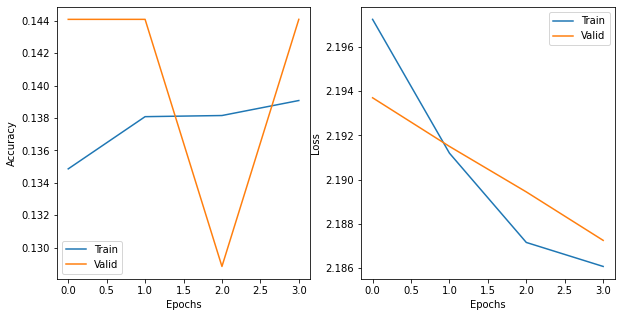

In [14]:
#  ## menampilkan history metrics akurasi dan loss 
import matplotlib.pyplot as plt

train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list = load_metrics(metrics_path)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(epochs_list, train_acc_list, label='Train')
ax1.plot(epochs_list, valid_acc_list, label='Valid')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs_list, train_loss_list, label='Train')
ax2.plot(epochs_list, valid_loss_list, label='Valid')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show() 

In [15]:
set_seed(42)

#Load model
mytokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')

myconfig = BertConfig.from_pretrained('indolem/indobert-base-uncased',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
myconfig.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
mymodel = BertForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', 
                                                      config=myconfig)


Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indober

In [16]:
# menggunakan gpu  
best_model = mymodel.to(device)

optimizer = optim.AdamW(best_model.parameters(), lr=learning_rate)

load_checkpoint(model_path, best_model, optimizer)

best_model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(best_model, batch_data[:-1], i2w=i2w, device=device_idx)
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()

100%|██████████| 1455/1455 [00:21<00:00, 66.17it/s]


In [17]:
## get y_test for user level
y_test_user_lvl = userlvltest.Lvalue
y_test_user_lvl.values

array([8, 6, 3, 0, 4, 1, 7, 4, 5, 1, 1, 7, 3, 5, 7, 0, 2, 4, 4, 2, 6, 2,
       7, 4, 2, 2, 1, 3, 2, 3, 1, 4, 1, 8, 2, 0, 1, 8, 6, 1, 8, 2, 2, 1,
       7, 4, 2, 3, 6, 0, 3, 4, 4, 3, 1, 5, 4, 0, 0, 2, 0, 4, 0, 3, 3, 3,
       7, 5, 7, 3, 3, 7, 3, 3, 3, 8, 3, 1, 6, 6, 5, 8, 5, 0, 1, 3, 7, 0,
       4, 8, 6, 0, 4, 2, 1, 5, 2, 5, 7, 8, 8, 6, 2, 4, 5, 4, 0, 7, 1, 2,
       0, 1, 8, 3, 8, 2, 0, 8, 4, 0, 4, 8, 2, 7, 3, 7, 2, 5, 6, 3, 3, 3,
       0, 4, 4, 0, 4, 8, 3, 2, 1, 1, 7, 6, 5, 5, 3, 1, 3, 6, 7, 8, 6, 5,
       2, 0, 2, 6, 1, 6, 8, 0, 7, 7, 1, 0, 4, 8, 8, 0, 6, 2, 4, 6, 4, 2,
       4, 8, 3, 1, 3, 6, 1, 6, 3, 8, 8, 1, 6, 0, 5, 8, 8, 3, 1, 2, 8, 2,
       0, 1, 2, 0, 4, 6, 2, 2, 6, 4, 0, 5, 6, 5, 4, 8, 5, 4, 7, 4, 3, 5,
       3, 8, 5, 2, 6, 8, 8, 5, 4, 4, 3, 7, 5, 2, 3, 0, 8, 1, 2, 1, 3, 4,
       1, 7, 4, 2, 5, 4, 3, 3])

In [18]:
## get y_pred for tweets level
y_pred_tweets_lvl = df.iloc[:,1].astype('category')
y_pred_tweets_lvl = y_pred_tweets_lvl.cat.codes

## get y_pred for user level
pred_tweets_lvl = test_df[['screen_name']].copy()
pred_tweets_lvl['Lpredict'] = y_pred_tweets_lvl.values

y_pred_user_lvl = pred_tweets_lvl.groupby(['screen_name'], sort=False).agg(lambda x:x.value_counts().index[0])
y_pred_user_lvl.Lpredict.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
from sklearn.metrics import classification_report

## print classification report for user level prediction
print('accuracy %s' % round(accuracy_score(y_pred_user_lvl, y_test_user_lvl),2 ))
print(classification_report(y_pred_user_lvl, y_test_user_lvl,target_names=label_dict.keys()))

accuracy 0.1
                            precision    recall  f1-score   support

    bali dan nusa tenggara       1.00      0.10      0.19       250
               jabodetabek       0.00      0.00      0.00         0
     jawa barat dan banten       0.00      0.00      0.00         0
jawa tengah dan yogyakarta       0.00      0.00      0.00         0
                jawa timur       0.00      0.00      0.00         0
                kalimantan       0.00      0.00      0.00         0
          maluku dan papua       0.00      0.00      0.00         0
                  sulawesi       0.00      0.00      0.00         0
                  sumatera       0.00      0.00      0.00         0

                  accuracy                           0.10       250
                 macro avg       0.11      0.01      0.02       250
              weighted avg       1.00      0.10      0.19       250



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
y_pred_tweets_lvl.to_csv('bert_result/indoLEM2e_5ResultsVote.csv')